In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from PIL import Image
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import pickle
import os
import torch.nn.functional as F
import requests
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sn
import pandas as pd
torch.manual_seed(1) 
from sklearn import preprocessing
from torch.utils.data import DataLoader, Dataset, Subset

mps_device = torch.device("mps")

# 1. Data Preparation

In [3]:
IMAGE_SIZE = 32

mean, std = [0.4914, 0.4822, 0.4465], [0.247, 0.243, 0.261]


composed_train = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), # Resize the image in a 32X32 shape
                                     transforms.RandomRotation(20), # Randomly rotate some images by 20 degrees
                                     transforms.RandomHorizontalFlip(0.1), # Randomly horizontal flip the images
                                     transforms.ColorJitter(brightness = 0.1, # Randomly adjust color jitter of the images
                                                            contrast = 0.1, 
                                                            saturation = 0.1), 
                                     transforms.RandomAdjustSharpness(sharpness_factor = 2,
                                                                      p = 0.1), # Randomly adjust sharpness
                                     transforms.ToTensor(),   # Converting image to tensor
                                     transforms.Normalize(mean, std), # Normalizing with standard mean and standard deviation
                                     transforms.RandomErasing(p=0.75,scale=(0.02, 0.1),value=1.0, inplace=False)])


composed_test = transforms.Compose([transforms.Resize((IMAGE_SIZE,IMAGE_SIZE)),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean, std)])


In [4]:
# Load the data and transform the dataset
train_dataset =  dsets.CIFAR10(root='./data', train=True, download=True, transform = composed_train)
validation_dataset = dsets.CIFAR10(root='./data', train=False, download=True, transform = composed_test)

# Create train and validation batch for training
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=100)

100%|████████████████████████████████████████| 170M/170M [02:20<00:00, 1.21MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


**Some important functions to print the images and image convertor from tensor to numpy**

In [5]:
def show_data(img):
    try:
        plt.imshow(img[0])
    except Exception as e:
        print(e)
    print(img[0].shape, img[0].permute(1,2,0).shape)
    plt.imshow(img[0].permute(1,2,0))
    plt.title('y = '+ str(img[1]))
    plt.show()
    
# We need to convert the images to numpy arrays as tensors are not compatible with matplotlib.
def im_convert(tensor):
    #Lets
    img = tensor.cpu().clone().detach().numpy() #
    img = img.transpose(1, 2, 0)
    img = img * np.array(tuple(mean)) + np.array(tuple(std))
    img = img.clip(0, 1) # Clipping the size to print the images later
    return img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Invalid shape (3, 32, 32) for image data
torch.Size([3, 32, 32]) torch.Size([32, 32, 3])


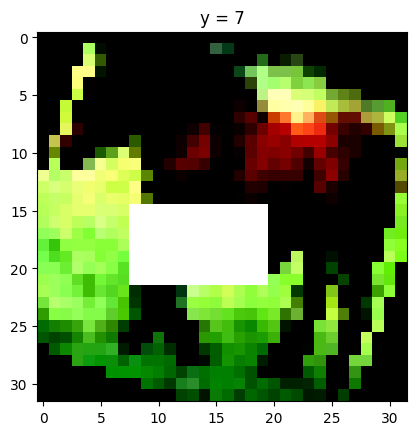

In [8]:
show_data(train_dataset[7])

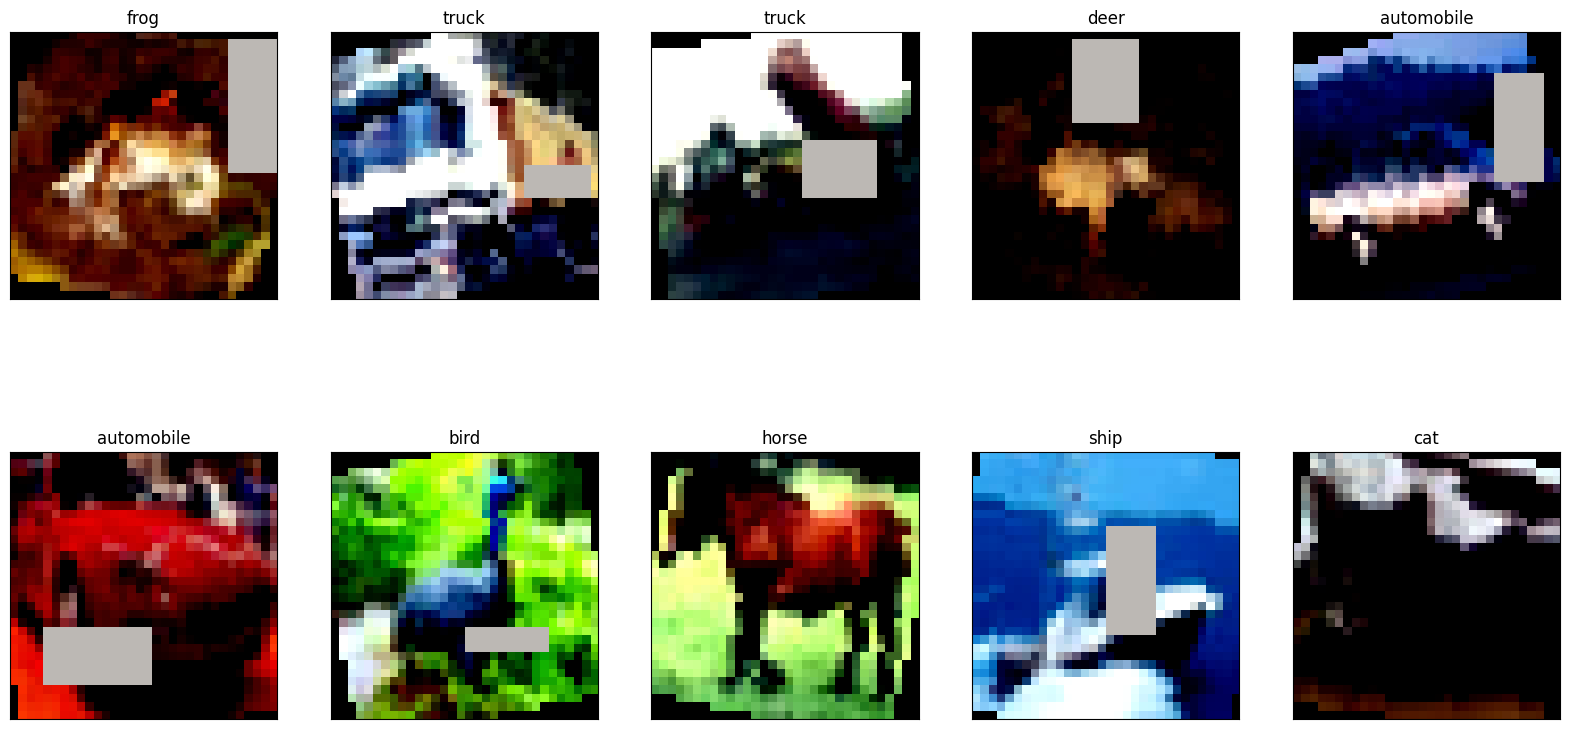

In [9]:
# Different classes in CIPHAR 10 dataset. 
classes = ('airplane', 
           'automobile', 
           'bird',
           'cat',
           'deer',
           'dog', 
           'frog', 
           'horse', 
           'ship',
           'truck')

# Define an iterable on the data
data_iterable = iter(train_loader) # converting our train_dataloader to iterable so that we can iter through it. 
images, labels = next(data_iterable) #going from 1st batch of 100 images to the next batch
fig = plt.figure(figsize=(20, 10)) 

# plot 50 images from our train_dataset
for idx in np.arange(10):
    ax = fig.add_subplot(2, 5, idx+1, xticks=[], yticks=[])
    
    
    # convert tensor image to numpy using im_convert function for imshow to print the image
    plt.imshow(im_convert(images[idx]))
    ax.set_title(classes[labels[idx].item()])

## 2. Convolution Neural Network Implementation

In [10]:
def train_model(model, train_loader, validation_loader, optimizer, n_epochs = 20):
    
    # Global variable
    N_test = len(validation_dataset)
    accuracy_list = []
    train_loss_list = []
    model = model.to(mps_device)
    train_cost_list = []
    val_cost_list = []
    
    for epoch in range(n_epochs):
        train_COST = 0
        for x,y in train_loader:
            x = x.to(mps_device)
            y = y.to(mps_device)
            model.train()
            optimizer.zero_grad()
            z = model(x)
            loss = criterion(z,y)
            loss.backward()
            optimizer.step()
            train_COST+=loss.item()
            
        train_COST = train_COST/len(train_loader)
        train_cost_list.append(train_COST)
        correct = 0
        
        # Perform the prediction on the validation data
        val_COST = 0
        for x_test, y_test in validation_loader:
            model.eval()
            x_test = x_test.to(mps_device)
            y_test = y_test.to(mps_device)
            z = model(x_test)
            val_loss = criterion(z, y_test)
            _, yhat = torch.max(z.data, 1)
            correct += (yhat==y_test).sum().item()
            val_COST+=val_loss.item()
        
        val_COST = val_COST/ len(validation_loader)
        val_cost_list.append(val_COST)
            
        accuracy = correct / N_test
        accuracy_list.append(accuracy)
        
        print("--> Epoch Number : {}".format(epoch + 1),
              " | Training Loss : {}".format(round(train_COST,4)),
              " | Validation Loss : {}".format(round(val_COST,4)),
              " | Validation Accuracy : {}%".format(round(accuracy * 100, 2)))
        
    return accuracy_list, train_cost_list, val_cost_list

In [11]:
class CNN(nn.Module):
    '''
    CNN Model V1: 
    1. 2 convolution + max pool layers 
    2. 1 fully connected layers
    3. Default runtime using 0 momentum and 0 dropout value
    '''
    
    # Constructor
    def __init__(self, out_1 = 32, out_2 = 64, number_of_classes = 10):
        super(CNN, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels = 3, out_channels = out_1, kernel_size = 5, padding = 2)
        self.maxpool1 = nn.MaxPool2d(kernel_size = 2)
        
        
        self.cnn2 = nn.Conv2d(in_channels = out_1, out_channels = out_2, kernel_size = 5, padding = 2)
        self.maxpool2 = nn.MaxPool2d(kernel_size = 2)
        self.fc1 = nn.Linear(out_2 * 8 * 8, number_of_classes)
        # Calculation of how we got 8*8 is mentioned in the below comment
        
    # Prediction
    def forward(self, x):
        x = self.cnn1(x)
        x = torch.relu(x)
        x = self.maxpool1(x)
        x = self.cnn2(x)
        x = torch.relu(x)
        x = self.maxpool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return(x)

**Define loss function, optimizer, dataset loader**

In [12]:
# Define the model
model = CNN(out_1=32, out_2=64, number_of_classes = 10)

# Define model training hyperparameters
criterion = nn.CrossEntropyLoss()
learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

# Train the model
accuracy_list_normal, train_cost_list, val_cost_list = train_model(model=model,n_epochs=20,train_loader=train_loader,validation_loader=validation_loader,optimizer=optimizer)

--> Epoch Number : 1  | Training Loss : 1.656  | Validation Loss : 1.3024  | Validation Accuracy : 54.0%
--> Epoch Number : 2  | Training Loss : 1.3334  | Validation Loss : 1.1586  | Validation Accuracy : 58.58%
--> Epoch Number : 3  | Training Loss : 1.2121  | Validation Loss : 1.0421  | Validation Accuracy : 63.5%
--> Epoch Number : 4  | Training Loss : 1.1332  | Validation Loss : 0.9783  | Validation Accuracy : 66.08%
--> Epoch Number : 5  | Training Loss : 1.0778  | Validation Loss : 0.9574  | Validation Accuracy : 66.34%
--> Epoch Number : 6  | Training Loss : 1.0374  | Validation Loss : 0.9584  | Validation Accuracy : 66.77%
--> Epoch Number : 7  | Training Loss : 1.0162  | Validation Loss : 0.9109  | Validation Accuracy : 68.83%
--> Epoch Number : 8  | Training Loss : 0.9846  | Validation Loss : 0.885  | Validation Accuracy : 69.47%
--> Epoch Number : 9  | Training Loss : 0.9627  | Validation Loss : 0.883  | Validation Accuracy : 70.04%
--> Epoch Number : 10  | Training Loss : 0

The above with momentum 0 gave less accurate results hence sticking back to momentum = 0.2

**iii) CNN Model V1 with momentum:**

In [13]:
# Define the model
model_mmt = CNN(out_1=32, out_2=64, number_of_classes = 10)

# Define the model learning hyperparameters
criterion = nn.CrossEntropyLoss()
learning_rate = 0.1
optimizer = torch.optim.SGD(model_mmt.parameters(), lr = learning_rate, momentum = 0.2)

# Train the model
accuracy_list_normal_mmt, train_cost_list_mmt, val_cost_list_mmt=train_model(model=model_mmt,n_epochs=20,train_loader=train_loader,validation_loader=validation_loader,optimizer=optimizer)

--> Epoch Number : 1  | Training Loss : 1.6272  | Validation Loss : 1.262  | Validation Accuracy : 55.01%
--> Epoch Number : 2  | Training Loss : 1.3085  | Validation Loss : 1.0928  | Validation Accuracy : 61.68%
--> Epoch Number : 3  | Training Loss : 1.1834  | Validation Loss : 0.9929  | Validation Accuracy : 65.26%
--> Epoch Number : 4  | Training Loss : 1.1156  | Validation Loss : 0.9436  | Validation Accuracy : 67.1%
--> Epoch Number : 5  | Training Loss : 1.0659  | Validation Loss : 0.9466  | Validation Accuracy : 67.36%
--> Epoch Number : 6  | Training Loss : 1.0392  | Validation Loss : 0.8986  | Validation Accuracy : 68.73%
--> Epoch Number : 7  | Training Loss : 1.0123  | Validation Loss : 0.9148  | Validation Accuracy : 68.58%
--> Epoch Number : 8  | Training Loss : 0.9837  | Validation Loss : 0.8964  | Validation Accuracy : 70.38%
--> Epoch Number : 9  | Training Loss : 0.9592  | Validation Loss : 0.8862  | Validation Accuracy : 70.68%
--> Epoch Number : 10  | Training Loss 

In [15]:
# Save model:
pickle.dump(model, open('./model/CNN_momentum_V1.pkl', 'wb'))



**iv) CNN Model V2:**

Added one more hidden layer in the Fully connected segment of the model.
Used momentum = 0.2 and dropout value = 0.5

In [16]:
class CNN_V2(nn.Module):    
    '''
    CNN Model V2: 
    1. 2 convolution & max pool layers 
    2. 2 fully connected layers
    3. Default runtime using 0.2 momentum and dropout value p = 0.5
    '''
    # Constructor
    def __init__(self, out_1 = 32, out_2 = 64, number_of_classes = 10, p = 0):
        super(CNN_V2, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels = 3, out_channels = out_1, kernel_size = 5, padding = 2)
        self.maxpool1 = nn.MaxPool2d(kernel_size = 2)
        
        
        self.cnn2 = nn.Conv2d(in_channels = out_1, out_channels = out_2, kernel_size = 5, padding = 2)
        self.maxpool2 = nn.MaxPool2d(kernel_size = 2)
        self.fc1 = nn.Linear(out_2 * 8 * 8, 1000) # Roughly taken seein the input and the output
        self.drop = nn.Dropout(p=p)
        self.fc2 = nn.Linear(1000, number_of_classes)
        
    # Prediction
    def forward(self, x):
        x = self.cnn1(x)
        x = torch.relu(x)
        x = self.maxpool1(x)
        x = self.cnn2(x)
        x = torch.relu(x)
        x = self.maxpool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = F.relu(self.drop(x))
        x = self.fc2(x)
        return(x)

In [17]:
# Define the model
model_mmtv2 = CNN_V2(out_1=32, out_2=64, number_of_classes = 10, p=0.5)

# Define model learning hyperparamters
criterion = nn.CrossEntropyLoss()
learning_rate = 0.1
optimizer = torch.optim.SGD(model_mmtv2.parameters(), lr = learning_rate, momentum = 0.2)

# Train the model
accuracy_list_normal, train_cost_list, val_cost_list=train_model(model=model_mmtv2,n_epochs=20,train_loader=train_loader,validation_loader=validation_loader,optimizer=optimizer)

--> Epoch Number : 1  | Training Loss : 1.6909  | Validation Loss : 1.343  | Validation Accuracy : 52.03%
--> Epoch Number : 2  | Training Loss : 1.3641  | Validation Loss : 1.1064  | Validation Accuracy : 60.53%
--> Epoch Number : 3  | Training Loss : 1.2084  | Validation Loss : 1.0144  | Validation Accuracy : 64.43%
--> Epoch Number : 4  | Training Loss : 1.1104  | Validation Loss : 0.9281  | Validation Accuracy : 67.3%
--> Epoch Number : 5  | Training Loss : 1.0396  | Validation Loss : 0.8854  | Validation Accuracy : 68.86%
--> Epoch Number : 6  | Training Loss : 0.9907  | Validation Loss : 0.8146  | Validation Accuracy : 71.69%
--> Epoch Number : 7  | Training Loss : 0.9411  | Validation Loss : 0.8214  | Validation Accuracy : 71.39%
--> Epoch Number : 8  | Training Loss : 0.9007  | Validation Loss : 0.7865  | Validation Accuracy : 73.09%
--> Epoch Number : 9  | Training Loss : 0.8696  | Validation Loss : 0.8096  | Validation Accuracy : 72.19%
--> Epoch Number : 10  | Training Loss 

In [18]:
# Save model
model_mmtv2 = model_mmtv2.to(torch.device("cpu"))
pickle.dump(model_mmtv2, open('./model/CNN_momentum_V2.pkl', 'wb'))

**v) CNN Model V3 :**

Added one more hidden layer in the Fully connected segment of the model.
Used momentum = 0.2 and dropout value = 0.5

In [19]:
class CNN_V3(nn.Module):
    '''
    CNN Model V3: 
    1. 2 convolution & max pool layers 
    2. 3 fully connected layers
    3. Default runtime using 0.2 momentum and dropout value p = 0.5
    '''

    def __init__(self, out_1 = 32, out_2 = 64, number_of_classes = 10, p = 0):
        super(CNN_V3, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels = 3, out_channels = out_1, kernel_size = 5, padding = 2)
        self.maxpool1 = nn.MaxPool2d(kernel_size = 2)
        
        self.cnn2 = nn.Conv2d(in_channels = out_1, out_channels = out_2, kernel_size = 5, padding = 2)
        self.maxpool2 = nn.MaxPool2d(kernel_size = 2)
        
        # Hidden layer 1
        self.fc1 = nn.Linear(out_2 * 8 * 8, 1000) 
        self.drop = nn.Dropout(p=p)
        
        # Hidden layer 2
        self.fc2 = nn.Linear(1000, 1000)
        
        # Final layer
        self.fc3 = nn.Linear(1000, 10)
        
    def forward(self, x):
        x = self.cnn1(x)
        x = torch.relu(x)
        x = self.maxpool1(x)
        x = self.cnn2(x)
        x = torch.relu(x)
        x = self.maxpool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = F.relu(self.drop(x))
        x = self.fc2(x)
        x = F.relu(self.drop(x))
        x = self.fc3(x)
        return(x)

In [20]:
# Define the model
model_mmtv3 = CNN_V3(out_1=32, out_2=64, number_of_classes = 10, p=0.5)

# Define the model training hyperparameters
criterion = nn.CrossEntropyLoss()
learning_rate = 0.1
optimizer = torch.optim.SGD(model_mmtv3.parameters(), lr = learning_rate, momentum = 0.2)

# Train the model
accuracy_list_normal, loss_list_normal=train_model(model=model_mmtv3,n_epochs=20,train_loader=train_loader,validation_loader=validation_loader,optimizer=optimizer)

--> Epoch Number : 1  | Training Loss : 1.7955  | Validation Loss : 1.4034  | Validation Accuracy : 49.01%
--> Epoch Number : 2  | Training Loss : 1.4601  | Validation Loss : 1.2206  | Validation Accuracy : 56.76%
--> Epoch Number : 3  | Training Loss : 1.3068  | Validation Loss : 1.0626  | Validation Accuracy : 63.17%
--> Epoch Number : 4  | Training Loss : 1.1984  | Validation Loss : 1.0044  | Validation Accuracy : 64.5%
--> Epoch Number : 5  | Training Loss : 1.1203  | Validation Loss : 0.9015  | Validation Accuracy : 68.41%
--> Epoch Number : 6  | Training Loss : 1.0588  | Validation Loss : 0.859  | Validation Accuracy : 70.72%
--> Epoch Number : 7  | Training Loss : 1.0028  | Validation Loss : 0.8477  | Validation Accuracy : 70.41%
--> Epoch Number : 8  | Training Loss : 0.9639  | Validation Loss : 0.803  | Validation Accuracy : 72.09%
--> Epoch Number : 9  | Training Loss : 0.9288  | Validation Loss : 0.7825  | Validation Accuracy : 72.52%
--> Epoch Number : 10  | Training Loss :

ValueError: too many values to unpack (expected 2)

In [21]:
model_mmtv3 = model_mmtv3.to(torch.device("cpu"))
pickle.dump(model_mmtv3, open('./model/CNN_momentum_V3.pkl', 'wb'))
#CNN_mom/entum_V3 - 2 CNN Layers, 2 hidden layers, Momentum = 0.2

**vi) CNN Model V3_V2 :**

Adding one more hidden layer & one more convolution layer

In [22]:
class CNN_V3_V2(nn.Module):
    
    '''
    CNN Model V3-V2: 
    1. 3 convolution & max pool layers 
    2. 3 fully connected layers
    3. Default runtime using 0.2 momentum and dropout value p = 0.5
    '''

    def __init__(self, out_1 = 32, out_2 = 64, out_3 = 128, number_of_classes = 10, p = 0):
        super(CNN_V3_V2, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels = 3, out_channels = out_1, kernel_size = 5, padding = 2)
        self.maxpool1 = nn.MaxPool2d(kernel_size = 2)
        
        self.cnn2 = nn.Conv2d(in_channels = out_1, out_channels = out_2, kernel_size = 5, padding = 2)
        self.maxpool2 = nn.MaxPool2d(kernel_size = 2)
        
        self.cnn3 = nn.Conv2d(in_channels = out_2, out_channels = out_3, kernel_size = 5, padding = 2)
        self.maxpool3 = nn.MaxPool2d(kernel_size = 2)
        
        # Hidden layer 1
        self.fc1 = nn.Linear(out_3 * 4 * 4, 1000) 
        # 8x8 will change to 4x4 as we added a convolution & max pool layer refer calculation comment above
        self.drop = nn.Dropout(p=p)
        
        # Hidden layer 2
        self.fc2 = nn.Linear(1000, 1000)
        
        # Final layer
        self.fc3 = nn.Linear(1000, 10)
        
    def forward(self, x):
        
        x = self.cnn1(x)
        x = torch.relu(x)
        x = self.maxpool1(x)
        
        x = self.cnn2(x)
        x = torch.relu(x)
        x = self.maxpool2(x)
        
        x = self.cnn3(x)
        x = torch.relu(x)
        x = self.maxpool3(x)
        
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        
        x = F.relu(self.drop(x))
        x = self.fc2(x)
        
        x = F.relu(self.drop(x))
        x = self.fc3(x)
        
        return(x)

In [23]:
# Define model
model_mmtv4 = CNN_V3_V2(out_1=32, out_2=64, out_3 =128, number_of_classes = 10, p=0.5)

# Define the model hyperparameters
criterion = nn.CrossEntropyLoss()
learning_rate = 0.1
optimizer = torch.optim.SGD(model_mmtv4.parameters(), lr = learning_rate, momentum = 0.2)

# Train the model
accuracy_list_normalv4, loss_list_normalv4=train_model(model=model_mmtv4, n_epochs=20, train_loader=train_loader, validation_loader=validation_loader, optimizer=optimizer)

--> Epoch Number : 1  | Training Loss : 1.8936  | Validation Loss : 1.4825  | Validation Accuracy : 45.62%
--> Epoch Number : 2  | Training Loss : 1.5096  | Validation Loss : 1.29  | Validation Accuracy : 53.27%
--> Epoch Number : 3  | Training Loss : 1.3323  | Validation Loss : 1.1364  | Validation Accuracy : 59.92%
--> Epoch Number : 4  | Training Loss : 1.2086  | Validation Loss : 0.9805  | Validation Accuracy : 65.83%
--> Epoch Number : 5  | Training Loss : 1.1156  | Validation Loss : 0.9256  | Validation Accuracy : 67.85%
--> Epoch Number : 6  | Training Loss : 1.0503  | Validation Loss : 0.9131  | Validation Accuracy : 68.04%
--> Epoch Number : 7  | Training Loss : 0.9918  | Validation Loss : 0.8513  | Validation Accuracy : 70.35%
--> Epoch Number : 8  | Training Loss : 0.9429  | Validation Loss : 0.813  | Validation Accuracy : 72.1%
--> Epoch Number : 9  | Training Loss : 0.9045  | Validation Loss : 0.7904  | Validation Accuracy : 72.85%
--> Epoch Number : 10  | Training Loss : 

ValueError: too many values to unpack (expected 2)

In [24]:
model_mmtv4 = model_mmtv4.to(torch.device("cpu"))
pickle.dump(model_mmtv4, open('./model/CNN_momentum_V4.pkl', 'wb'))
#CNN_momentum_V4 - 3 CNN Layers, 2 hidden layers, Momentum = 0.2

**vii) CNN Model V3-V3 :**

Adding one more fully connected layer and initializing weights using He initialization

In [25]:
class CNN_V3_V3(nn.Module):
    '''
    CNN Model V3-V2: 
    1. 3 convolution & max pool layers 
    2. 4 fully connected layers
    3. Default runtime using 0.2 momentum and dropout value p = 0.5
    4. Weights initialized using He weight initialization
    '''
    def __init__(self, out_1 = 32, out_2 = 64, out_3 = 128, number_of_classes = 10, p = 0):
        super(CNN_V3_V3, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels = 3, out_channels = out_1, kernel_size = 5, padding = 2)
        self.maxpool1 = nn.MaxPool2d(kernel_size = 2)
        
        self.cnn2 = nn.Conv2d(in_channels = out_1, out_channels = out_2, kernel_size = 5, padding = 2)
        self.maxpool2 = nn.MaxPool2d(kernel_size = 2)
        
        self.cnn3 = nn.Conv2d(in_channels = out_2, out_channels = out_3, kernel_size = 5, padding = 2)
        self.maxpool3 = nn.MaxPool2d(kernel_size = 2)
        
        # Hidden layer 1
        self.fc1 = nn.Linear(out_3 * 4 * 4, 1000) 
        torch.nn.init.kaiming_uniform_(self.fc1.weight, nonlinearity='relu')
        self.drop = nn.Dropout(p=p)
        
        # Hidden layer 2
        self.fc2 = nn.Linear(1000, 1000)
        torch.nn.init.kaiming_uniform_(self.fc2.weight, nonlinearity='relu') # He weight initialization

        # Hidden layer 3
        self.fc3 = nn.Linear(1000, 1000)
        torch.nn.init.kaiming_uniform_(self.fc3.weight, nonlinearity='relu') # He weight initialization
        
        # Final layer
        self.fc4 = nn.Linear(1000, 10)
        torch.nn.init.kaiming_uniform_(self.fc4.weight, nonlinearity='relu') # He weight initialization
        
    def forward(self, x):
        
        x = self.cnn1(x)
        x = torch.relu(x)
        x = self.maxpool1(x)
        
        x = self.cnn2(x)
        x = torch.relu(x)
        x = self.maxpool2(x)
        
        x = self.cnn3(x)
        x = torch.relu(x)
        x = self.maxpool3(x)
        
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        
        x = F.relu(self.drop(x))
        x = self.fc2(x)
        
        x = F.relu(self.drop(x))
        x = self.fc3(x)

        x = F.relu(self.drop(x))
        x = self.fc4(x)
        
        return(x)

In [27]:
# Define the model
model_mmtv5 = CNN_V3_V3(out_1=32, out_2=64, out_3 =128, number_of_classes = 10, p=0.5)
criterion = nn.CrossEntropyLoss()
learning_rate = 0.1
optimizer = torch.optim.SGD(model_mmtv5.parameters(), lr = learning_rate, momentum = 0.2)

# Train the model
accuracy_list_normalv5, loss_list_normalv5=train_model(model=model_mmtv5, n_epochs=20, train_loader=train_loader, validation_loader=validation_loader, optimizer=optimizer)

--> Epoch Number : 1  | Training Loss : 1.9782  | Validation Loss : 1.5841  | Validation Accuracy : 40.7%
--> Epoch Number : 2  | Training Loss : 1.6326  | Validation Loss : 1.3882  | Validation Accuracy : 49.07%
--> Epoch Number : 3  | Training Loss : 1.4882  | Validation Loss : 1.2924  | Validation Accuracy : 54.05%
--> Epoch Number : 4  | Training Loss : 1.3932  | Validation Loss : 1.1509  | Validation Accuracy : 59.22%
--> Epoch Number : 5  | Training Loss : 1.3215  | Validation Loss : 1.0991  | Validation Accuracy : 62.21%
--> Epoch Number : 6  | Training Loss : 1.265  | Validation Loss : 1.049  | Validation Accuracy : 62.79%
--> Epoch Number : 7  | Training Loss : 1.2059  | Validation Loss : 0.9878  | Validation Accuracy : 65.53%
--> Epoch Number : 8  | Training Loss : 1.1638  | Validation Loss : 0.9431  | Validation Accuracy : 67.58%
--> Epoch Number : 9  | Training Loss : 1.1301  | Validation Loss : 0.9478  | Validation Accuracy : 67.84%
--> Epoch Number : 10  | Training Loss :

ValueError: too many values to unpack (expected 2)

In [28]:
model_mmtv5 = model_mmtv5.to(torch.device("cpu"))
pickle.dump(model_mmtv5, open('./model/CNN_momentum_V5.pkl', 'wb'))
#CNN_momentum_V5 - 3 CNN Layers, 2 hidden layers, Momentum = 0.2, He Weight initialization

In [29]:
class CNN_V3_V4(nn.Module):
    """
    Adding one more hidden layer & dropout value & one more convolution layer
    Total 3 hidden layers, 3 convolution layer & Batch Normalization
    """
    def __init__(self, out_1 = 32, out_2 = 64, out_3 = 128, number_of_classes = 10, p = 0):
        super(CNN_V3_V4, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels = 3, out_channels = out_1, kernel_size = 5, padding = 2)
        self.maxpool1 = nn.MaxPool2d(kernel_size = 2)
        self.conv1_bn = nn.BatchNorm2d(out_1)
        self.drop_conv = nn.Dropout(p=0.2)
        
        self.cnn2 = nn.Conv2d(in_channels = out_1, out_channels = out_2, kernel_size = 5, padding = 2)
        self.maxpool2 = nn.MaxPool2d(kernel_size = 2)
        self.conv2_bn = nn.BatchNorm2d(out_2)
        
        self.cnn3 = nn.Conv2d(in_channels = out_2, out_channels = out_3, kernel_size = 5, padding = 2)
        self.maxpool3 = nn.MaxPool2d(kernel_size = 2)
        self.conv3_bn = nn.BatchNorm2d(out_3)
        
        # Hidden layer 1
        self.fc1 = nn.Linear(out_3 * 4 * 4, 1000) 
        self.drop = nn.Dropout(p=p)
        self.fc1_bn = nn.BatchNorm1d(1000)
        
        # Hidden layer 2
        self.fc2 = nn.Linear(1000, 1000)
        self.fc2_bn = nn.BatchNorm1d(1000)

        # Hidden layer 3
        self.fc3 = nn.Linear(1000, 1000)
        self.fc3_bn = nn.BatchNorm1d(1000)
        
        # Hidden layer 4
        self.fc4 = nn.Linear(1000, 1000)
        self.fc4_bn = nn.BatchNorm1d(1000)
        
        # Final layer
        self.fc5 = nn.Linear(1000, 10)
        self.fc5_bn = nn.BatchNorm1d(10)
        
    def forward(self, x):
        
        x = self.cnn1(x)
        x = self.conv1_bn(x)
        x = self.maxpool1(x)
        x = self.drop_conv(x)
        
        x = self.cnn2(x)
        x = self.conv2_bn(x)
        x = torch.relu(x)
        x = self.maxpool2(x)
        x = self.drop_conv(x)
        
        x = self.cnn3(x)
        x = self.conv3_bn(x)
        x = torch.relu(x)
        x = self.maxpool3(x)
        x = self.drop_conv(x)
        
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc1_bn(x)
        
        x = F.relu(self.drop(x))
        x = self.fc2(x)
        x = self.fc2_bn(x)
        
        x = F.relu(self.drop(x))
        x = self.fc3(x)
        x = self.fc3_bn(x)
        
        x = F.relu(self.drop(x))
        x = self.fc4(x)
        x = self.fc4_bn(x)

        x = F.relu(self.drop(x))
        x = self.fc5(x)
        x = self.fc5_bn(x)
        
        return(x)

In [30]:
model_mmtv5 = CNN_V3_V4(out_1=32, out_2=64, out_3 =128, number_of_classes = 10, p=0.5)
criterion = nn.CrossEntropyLoss()
learning_rate = 0.1
optimizer = torch.optim.SGD(model_mmtv5.parameters(), lr = learning_rate, momentum = 0.2)

# Train the model
accuracy_list_normalv5, train_cost_listv5, val_cost_listv5=train_model(model=model_mmtv5, n_epochs=20, train_loader=train_loader, validation_loader=validation_loader, optimizer=optimizer)

--> Epoch Number : 1  | Training Loss : 1.739  | Validation Loss : 1.4121  | Validation Accuracy : 48.35%
--> Epoch Number : 2  | Training Loss : 1.4655  | Validation Loss : 1.1725  | Validation Accuracy : 57.18%
--> Epoch Number : 3  | Training Loss : 1.3391  | Validation Loss : 1.058  | Validation Accuracy : 62.28%
--> Epoch Number : 4  | Training Loss : 1.2612  | Validation Loss : 0.9704  | Validation Accuracy : 65.11%
--> Epoch Number : 5  | Training Loss : 1.1951  | Validation Loss : 0.8995  | Validation Accuracy : 68.23%
--> Epoch Number : 6  | Training Loss : 1.1492  | Validation Loss : 0.874  | Validation Accuracy : 69.45%
--> Epoch Number : 7  | Training Loss : 1.1047  | Validation Loss : 0.8277  | Validation Accuracy : 70.73%
--> Epoch Number : 8  | Training Loss : 1.0711  | Validation Loss : 0.8018  | Validation Accuracy : 71.87%
--> Epoch Number : 9  | Training Loss : 1.0468  | Validation Loss : 0.7673  | Validation Accuracy : 73.2%
--> Epoch Number : 10  | Training Loss : 

In [31]:
# Save the model
model_mmtv5 = model_mmtv5.to(torch.device("cpu"))
pickle.dump(model_mmtv5, open('./model/CNN_momentum_V8_12_01_23.pkl', 'wb'))
#CNN_momentum_V5 - 3 CNN Layers, 3 hidden layers, Momentum = 0.2



# 3. Model Performance Report & Error Analysis

**i) Printing model training loss vs accuracy:**

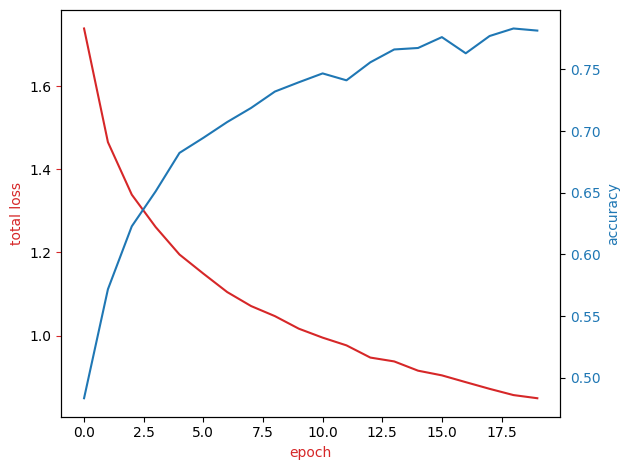

In [32]:
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.plot(train_cost_listv5,color=color)
ax1.set_xlabel('epoch',color=color)
ax1.set_ylabel('total loss',color=color)
ax1.tick_params(axis='y', color=color)
    
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('accuracy', color=color)  
ax2.plot( accuracy_list_normalv5, color=color)
ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()

**ii) Printing training and validation loss:**

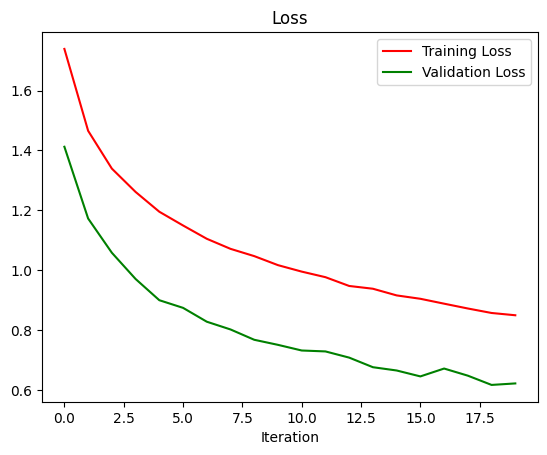

In [33]:
plt.plot(train_cost_listv5, 'r', label='Training Loss')
plt.plot(val_cost_listv5,  'g',  label='Validation Loss')
plt.xlabel("Iteration")
plt.title("Loss")
plt.legend()



the training loss and validation loss are close to each other hence avoiding our model to overfit

**iii) Error Analysis: Printing Confusion Matrix & Classification Report :**

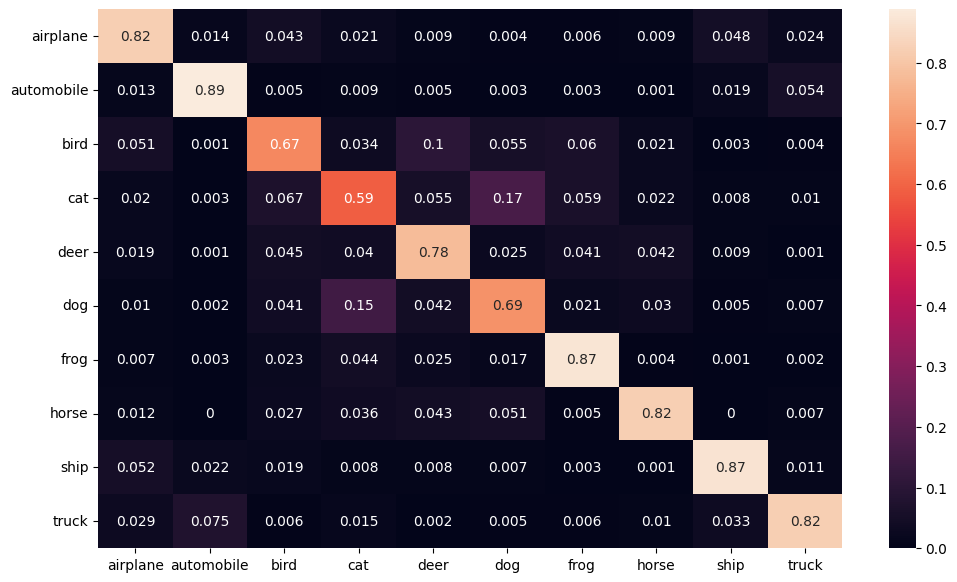

In [40]:
model_mmtv5 = model_mmtv5.to(mps_device)

y_pred = []
y_true = []

# Iterate over test data
for x, y in torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=1):
    # Move input and labels to the MPS device
    x = x.to(mps_device)
    y = y.to(mps_device)
    
    # Forward pass
    z = model_mmtv5(x)
    _, yhat = torch.max(z, 1)
    
    # Convert predictions and true labels to numpy
    pred = yhat.data.cpu().numpy()
    y_pred.extend(pred)  # Save predictions

    labels = y.data.cpu().numpy()
    y_true.extend(labels)  # Save ground truth

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix) * 10, 
                     index=[i for i in classes], 
                     columns=[i for i in classes])

# Plot confusion matrix
plt.figure(figsize=(12, 7))
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')

In [44]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.82      0.81      1000
           1       0.88      0.89      0.88      1000
           2       0.71      0.67      0.69      1000
           3       0.62      0.59      0.60      1000
           4       0.73      0.78      0.75      1000
           5       0.67      0.69      0.68      1000
           6       0.81      0.87      0.84      1000
           7       0.85      0.82      0.84      1000
           8       0.87      0.87      0.87      1000
           9       0.87      0.82      0.84      1000

    accuracy                           0.78     10000
   macro avg       0.78      0.78      0.78     10000
weighted avg       0.78      0.78      0.78     10000



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Invalid shape (3, 32, 32) for image data
torch.Size([3, 32, 32]) torch.Size([32, 32, 3])


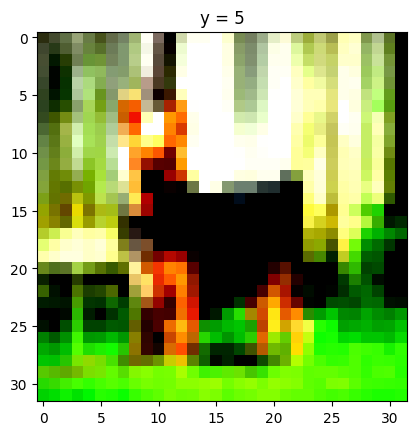

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


yhat:  tensor([4], device='mps:0')
Invalid shape (3, 32, 32) for image data
torch.Size([3, 32, 32]) torch.Size([32, 32, 3])


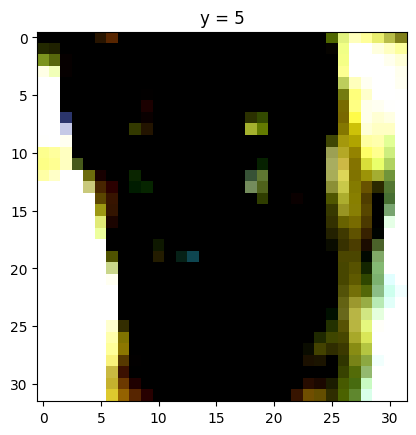

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


yhat:  tensor([3], device='mps:0')
Invalid shape (3, 32, 32) for image data
torch.Size([3, 32, 32]) torch.Size([32, 32, 3])


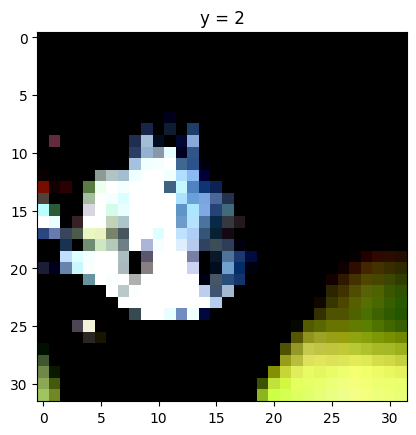

yhat:  tensor([1], device='mps:0')


In [45]:
# Plot the mis-classified samples
count = 0
i = 0
for x, y in torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=1):
    #print('iter val', i)
    x = x.to(mps_device)
    y = y.to(mps_device)
    z = model_mmtv5(x)
    _, yhat = torch.max(z, 1)
    if yhat != y:
        show_data(validation_dataset[i])
        plt.show()
        print("yhat: ",yhat)
        count += 1
    if count >= 3:
        break
    i+=1

**iv) Printing how out model performs on the first 20 images:**

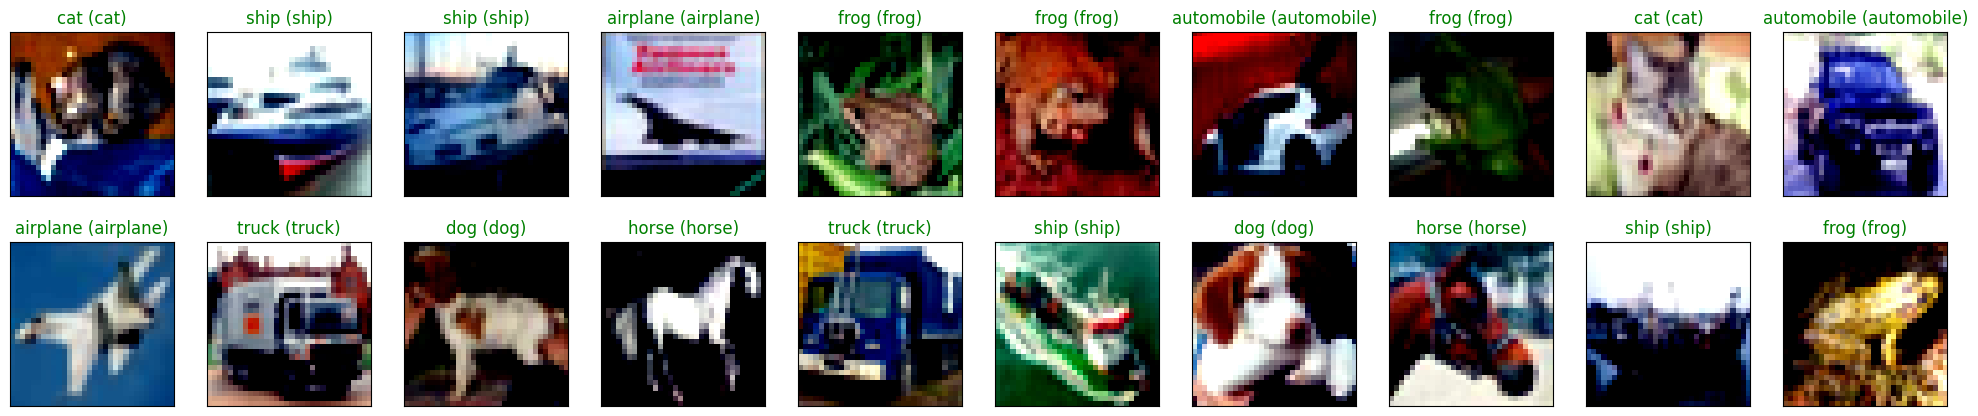

In [46]:
data_iterable = iter(validation_loader)
images, labels = next(data_iterable)
images = images.to(mps_device)
labels = labels.to(mps_device)
output = model_mmtv5(images)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(25, 5))

for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx]))
    ax.set_title("{} ({})".format(str(classes[preds[idx].item()]), str(classes[labels[idx].item()])), color=("green" if preds[idx]==labels[idx] else "red"))

# 4. Performance on Hold-Out Set

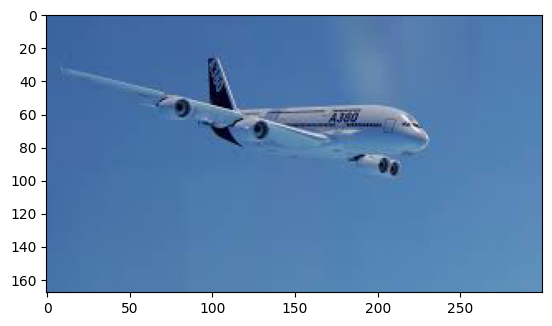

In [47]:
# Ex1

url = 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRsa3ISspmdRq4nDC9M6pfoNh1TvukFHBzGuA&usqp=CAU'
response = requests.get(url, stream = True)
img = Image.open(response.raw)
plt.imshow(img)

# Image cleared to reduce size of ipynb file

Prediction by Model: airplane


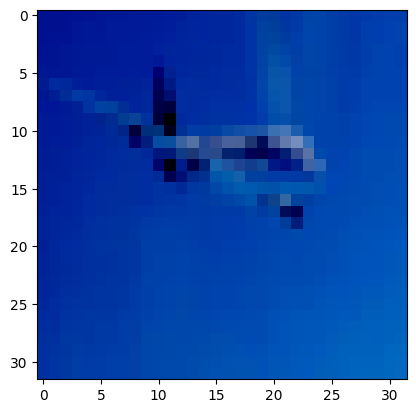

In [48]:
# Convert holdout image to testing format
img = composed_test(img)  
plt.imshow(im_convert(img)) 

image = img.to(mps_device).unsqueeze(0) 
output = model_mmtv5(image)
_, pred = torch.max(output, 1)
print("Prediction by Model:", (classes[pred.item()]))

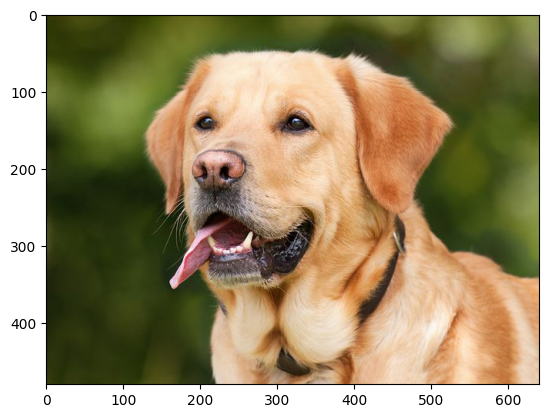

In [49]:
# Ex2

url = 'https://cdn.pixabay.com/photo/2016/02/19/15/46/labrador-retriever-1210559__480.jpg'
response = requests.get(url, stream = True)
img = Image.open(response.raw)
plt.imshow(img)

# Image cleared to reduce size of ipynb file

Prediction by Model: dog


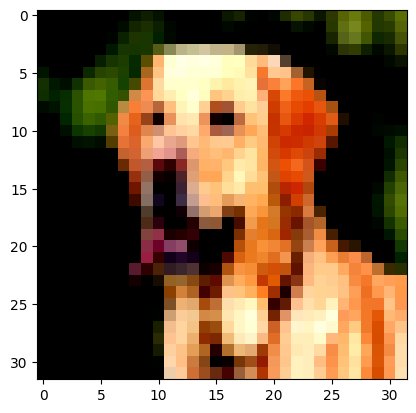

In [50]:
# Convert holdout image to testing format
img = composed_test(img)
plt.imshow(im_convert(img)) 
image = img.to(mps_device).unsqueeze(0)
output = model_mmtv5(image)
_, pred = torch.max(output, 1)
print("Prediction by Model:", (classes[pred.item()]))

# 5. Prediction on Test

In [51]:
class TestImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        # Define the path where images are stored by yourself.
        # Remember, the first image is ./train/1.png
        img_path = self.img_dir + '/' + str(self.img_labels.iloc[idx, 0]) +'.png'

        # Read image. Recall how you converted an image to numpy array in the previous step.
        image = np.asarray(Image.open(img_path).convert('RGB'))

        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [67]:
import pickle
import numpy as np
import torch
from torchvision import transforms
from torch.utils.data import Dataset

test_batch_path = "data/cifar-10-batches-py/test_batch"

def load_cifar10_batch(batch_path):
    with open(batch_path, 'rb') as file:
        batch = pickle.load(file, encoding='latin1')  
    images = batch['data']
    labels = batch['labels']
    return images, labels

# Load test data
test_images, test_labels = load_cifar10_batch(test_batch_path)

test_images = test_images.reshape(-1, 3, 32, 32).astype(np.uint8)  

mean = [0.4914, 0.4822, 0.4465]
std = [0.2023, 0.1994, 0.2010]

# Transform pipeline for test images
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# Custom Dataset for CIFAR-10 test data
class CIFAR10TestDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        # Convert to PIL Image for torchvision transforms
        image = np.transpose(image, (1, 2, 0))  # Convert (C, H, W) to (H, W, C) for PIL
        if self.transform:
            image = transforms.ToPILImage()(image)
            image = self.transform(image)

        return image, label

test_dataset = CIFAR10TestDataset(test_images, test_labels, transform=transform)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1000, shuffle=False)

for X_test, y_test in test_loader:
    print(f"Batch X_test shape: {X_test.shape}")
    print(f"Batch y_test shape: {y_test.shape}")
    break


Batch X_test shape: torch.Size([1000, 3, 32, 32])
Batch y_test shape: torch.Size([1000])


In [71]:
composed_test_check = transforms.Compose([transforms.ToPILImage(), 
                                          transforms.Resize((IMAGE_SIZE,IMAGE_SIZE)),
                                          transforms.ToTensor(),
                                          transforms.Normalize(mean, std)])



label_encoder = preprocessing.LabelEncoder()   
label_encoder.fit_transform(list(classes))

# Iteratively predict the target and update the submission file
model_mmtv5 = model_mmtv5.to(mps_device)
i = 0
y_test_pred_list = []
for X_test, _ in torch.utils.data.DataLoader(dataset=test_dataset, batch_size=1000):

    X_test = X_test.to(mps_device) # Move X_train to the GPU
    model_mmtv5.eval()

    _, y_test_pred = torch.max(model_mmtv5(X_test), 1) # Pick the most probable label

    # Move the predicted values to CPU.
    y_test_pred = y_test_pred.cpu()   

    y_test_pred = label_encoder.inverse_transform(y_test_pred)
    y_test_pred_list.extend(y_test_pred)
    

In [72]:

device = torch.device("mps" if torch.has_mps else "cuda" if torch.cuda.is_available() else "cpu")
model_mmtv5 = model_mmtv5.to(device)

model_mmtv5.eval()

correct = 0
total = 0

# No gradient computation needed during evaluation
with torch.no_grad():
    for X_test, y_test in test_loader:
        # Move test data to the correct device
        X_test, y_test = X_test.to(device), y_test.to(device)

        # Get model predictions
        outputs = model_mmtv5(X_test)
        _, predicted = torch.max(outputs, 1)

        # Update total and correct counts
        total += y_test.size(0)
        correct += (predicted == y_test).sum().item()

accuracy = correct / total * 100
print(f"Test Accuracy: {accuracy:.2f}%")


/var/folders/mn/0fq8htyd3jv16wb8bvhgr1gw0000gn/T/ipykernel_10718/1157643068.py:2: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  device = torch.device("mps" if torch.has_mps else "cuda" if torch.cuda.is_available() else "cpu")


Test Accuracy: 78.06%
